### Package Installation & Setup

This Notebook utilizes several packages to work with IFC files, perform geometric operations, and interact with a graph database. Below is a brief introduction to the key packages used and their installation setup.

1. **ifcopenshell**: This package is used to read and manipulate IFC (Industry Foundation Classes) files, which are commonly used in Building Information Modeling (BIM). It provides tools to parse and interact with IFC data.

2. **ifcopenshell.geom**: This module within ifcopenshell is used for geometric operations on IFC elements, such as creating geometric representations and detecting clashes.

3. **networkx**: A Python library for creating, manipulating, and studying complex networks of nodes and edges. It is used here to represent the IFC data as a graph.

4. **nx_arangodb**: This package integrates NetworkX with ArangoDB, allowing for the storage and querying of graph data within an ArangoDB database.

5. **ArangoClient**: A client for interacting with ArangoDB, a multi-model database that supports graph, document, and key/value data models.

6. **gradio**: A Python library for creating interactive user interfaces for machine learning models. It is used here to create a web-based interface for interacting with the IFC data and graph queries.

7. **langchain**: A framework for building applications with large language models. It is used here to create agents that can interact with the graph data using natural language queries.

### Installation

To install the required packages, you can use the following pip commands:


In [ ]:
from arango import ArangoClient
import nx_arangodb as nxadb
import networkx as nx
import json


[21:15:47 +0300] [INFO]: NetworkX-cuGraph is unavailable: No module named 'cupy'.


In [ ]:
import ifcopenshell
ifc_file = ifcopenshell.open("Ifc4_SampleHouse.ifc")

rooted_elements = ifc_file.by_type("IfcRoot") 


In [4]:
db = ArangoClient(hosts="https://8af8f2910ce9.arangodb.cloud:8529").db(username='root', password='tTNs1uzb6lPpLMa6Cmka')
print(db)

<StandardDatabase _system>


### Preparaing the IFC dataset for NetworkX

In [ ]:
graph = nx.Graph()
graph.add_node("rootnode",type='root')

def add_object_in_tree(ifc_child_node, ifc_parent_node):
    graph.add_edge(str(ifc_parent_node), str(ifc_child_node.id()))

    node_att = ifc_child_node.get_info()
    for k,v in node_att.items():
         if(type(v) != str):
            node_att[k] = '{}'.format(v)

    nx.set_node_attributes(graph,{str(ifc_child_node.id()) : node_att})


    # only spatial elements can contain building elements
    if ifc_child_node.is_a("IfcSpatialStructureElement"):
        # using IfcRelContainedInSpatialElement to get contained elements
        for rel in ifc_child_node.ContainsElements:
            related_elements = rel.RelatedElements
            for element in related_elements:
                add_object_in_tree(element, ifc_child_node.id())
    # using IfcRelAggregates to get spatial decomposition of spatial structure elements
    if ifc_child_node.is_a("IfcObjectDefinition"):
        for rel in ifc_child_node.IsDecomposedBy:
            related_objects = rel.RelatedObjects
            for related_object in related_objects:
                add_object_in_tree(related_object, ifc_child_node.id())

items = ifc_file.by_type('IfcProject')
for item in items:
	add_object_in_tree(item,"rootnode")

print(graph.nodes['38397'])


{'id': '38397', 'type': 'IfcFurniture', 'GlobalId': '3cUkl32yn9qRSPvBJVyZ$$', 'OwnerHistory': '#42=IfcOwnerHistory(#39,#5,$,.NOCHANGE.,$,$,$,1418982422)', 'Name': 'Furniture_Table_Dining_w-Chairs_Rectangular:2000x1000x750mm_w-6_Seats:289768', 'Description': 'None', 'ObjectType': '2000x1000x750mm_w-6_Seats', 'ObjectPlacement': '#38395=IfcLocalPlacement(#140,#38394)', 'Representation': '#38385=IfcProductDefinitionShape($,$,(#38383))', 'Tag': '289768', 'PredefinedType': 'None'}


In [ ]:
def collect_nodes_with_attributes_bfs(graph, start_node, attribute_name, attribute_values):
    """
    Traverses a graph using Breadth-First Search and collects nodes with specific attribute values.

    Args:
        graph (nx.Graph): The graph to traverse.
        start_node: The node to start the BFS from.
        attribute_name (str): The name of the node attribute to check.
        attribute_values (list): A list of attribute values to match.

    Returns:
        list: A list of nodes that have the specified attribute values.
    """
    collected_nodes = []
    visited = set()
    queue = [start_node]
    visited.add(start_node)

    while queue:
        current_node = queue.pop(0)

        if attribute_name in graph.nodes[current_node] and graph.nodes[current_node][attribute_name] in attribute_values:
            collected_nodes.append(current_node)

        for neighbor in graph.neighbors(current_node):
            if neighbor not in visited:
                visited.add(neighbor)
                queue.append(neighbor)

    return collected_nodes

atrs = collect_nodes_with_attributes_bfs(graph, "rootnode", "type", 'IfcFurniture')


[{'id': '38397', 'type': 'IfcFurniture', 'GlobalId': '3cUkl32yn9qRSPvBJVyZ$$', 'OwnerHistory': '#42=IfcOwnerHistory(#39,#5,$,.NOCHANGE.,$,$,$,1418982422)', 'Name': 'Furniture_Table_Dining_w-Chairs_Rectangular:2000x1000x750mm_w-6_Seats:289768', 'Description': 'None', 'ObjectType': '2000x1000x750mm_w-6_Seats', 'ObjectPlacement': '#38395=IfcLocalPlacement(#140,#38394)', 'Representation': '#38385=IfcProductDefinitionShape($,$,(#38383))', 'Tag': '289768', 'PredefinedType': 'None'}]
[{'id': '40020', 'type': 'IfcFurniture', 'GlobalId': '3cUkl32yn9qRSPvBJVyZ$_', 'OwnerHistory': '#42=IfcOwnerHistory(#39,#5,$,.NOCHANGE.,$,$,$,1418982422)', 'Name': 'Chair - Dining:Chair - Dining:289769', 'Description': 'None', 'ObjectType': 'Chair - Dining', 'ObjectPlacement': '#40019=IfcLocalPlacement(#140,#40018)', 'Representation': '#40009=IfcProductDefinitionShape($,$,(#40007))', 'Tag': '289769', 'PredefinedType': 'None'}]
[{'id': '41597', 'type': 'IfcFurniture', 'GlobalId': '3cUkl32yn9qRSPvBJVyZ$z', 'OwnerHi

[{'id': '40020',
  'type': 'IfcFurniture',
  'GlobalId': '3cUkl32yn9qRSPvBJVyZ$_',
  'OwnerHistory': '#42=IfcOwnerHistory(#39,#5,$,.NOCHANGE.,$,$,$,1418982422)',
  'Name': 'Chair - Dining:Chair - Dining:289769',
  'Description': 'None',
  'ObjectType': 'Chair - Dining',
  'ObjectPlacement': '#40019=IfcLocalPlacement(#140,#40018)',
  'Representation': '#40009=IfcProductDefinitionShape($,$,(#40007))',
  'Tag': '289769',
  'PredefinedType': 'None'}]

In [ ]:

def graph_to_hierarchical_json(graph, root_node=None):
    """
    Converts a NetworkX graph to a hierarchical JSON representation.

    Args:
        graph (nx.Graph): The NetworkX graph.
        root_node: The root node for the hierarchy (optional). If None, a root is inferred.

    Returns:
        str: A JSON string representing the hierarchical structure.
    """

    if not graph.nodes:
        return json.dumps({})  # Empty graph

    if root_node is None:
            root_node = next(iter(graph.nodes))

    def build_hierarchy(node):
        node_data = { str(graph.nodes[node]['type']) : []}
        neighbors = list(graph.neighbors(node))
        for neighbor in neighbors:
          if neighbor != root_node: #avoid circular references
            if neighbor not in visited:
              visited.add(neighbor)
              node_data[str(graph.nodes[node]['type'])].append(build_hierarchy(neighbor))
        return node_data

    visited = {root_node} #prevent infinite loops in cyclic graphs.
    hierarchy = build_hierarchy(root_node)

    return json.dumps(hierarchy, indent=4)

hierarchical_json = graph_to_hierarchical_json(graph)

In [18]:
list(graph.nodes(data=True))

[('rootnode', {'type': 'root'}),
 ('103',
  {'id': '103',
   'type': 'IfcProject',
   'GlobalId': '1o0c33arXF9AEePDXPKItb',
   'OwnerHistory': '#42=IfcOwnerHistory(#39,#5,$,.NOCHANGE.,$,$,$,1418982422)',
   'Name': 'Project Number',
   'Description': 'None',
   'ObjectType': 'None',
   'LongName': 'Project Name',
   'Phase': 'Project Status',
   'RepresentationContexts': "(#95=IfcGeometricRepresentationContext($,'Model',3,0.01,#92,#93),)",
   'UnitsInContext': '#90=IfcUnitAssignment((#43,#45,#46,#50,#52,#53,#54,#56,#60,#65,#67,#68,#69,#70,#71,#72,#73,#78,#82,#84,#88))'}),
 ('82887',
  {'id': '82887',
   'type': 'IfcSite',
   'GlobalId': '1o0c33arXF9AEePDXPKItd',
   'OwnerHistory': '#42=IfcOwnerHistory(#39,#5,$,.NOCHANGE.,$,$,$,1418982422)',
   'Name': 'Default',
   'Description': 'None',
   'ObjectType': '',
   'ObjectPlacement': '#82886=IfcLocalPlacement($,#82885)',
   'Representation': 'None',
   'LongName': 'None',
   'CompositionType': 'ELEMENT',
   'RefLatitude': '(51, 30, 0, 5493

In [7]:
import gradio as gr
import json

def json_to_markdown_hierarchy(json_data):
    """Converts a JSON hierarchy to a Markdown representation."""
    try:
        data = json.loads(json_data)
    except json.JSONDecodeError:
        return "Invalid JSON input."

    def build_markdown(data, level=0):
        markdown = ""
        for key, value in data.items():
            markdown += f"{'  ' * level}- **<span style='font-size: 1.2em;'>{key}</span>**\n"
            if isinstance(value, list) and value:
                for item in value:
                    if isinstance(item, dict):
                        markdown += build_markdown(item, level + 1)
        return markdown

    if "root" in data and isinstance(data["root"], list) and data["root"]:
        markdown_output = build_markdown(data["root"][0])
    else:
        markdown_output = "Invalid JSON structure. Root element not found or is empty."

    return markdown_output


Graph with 70 nodes and 69 edges


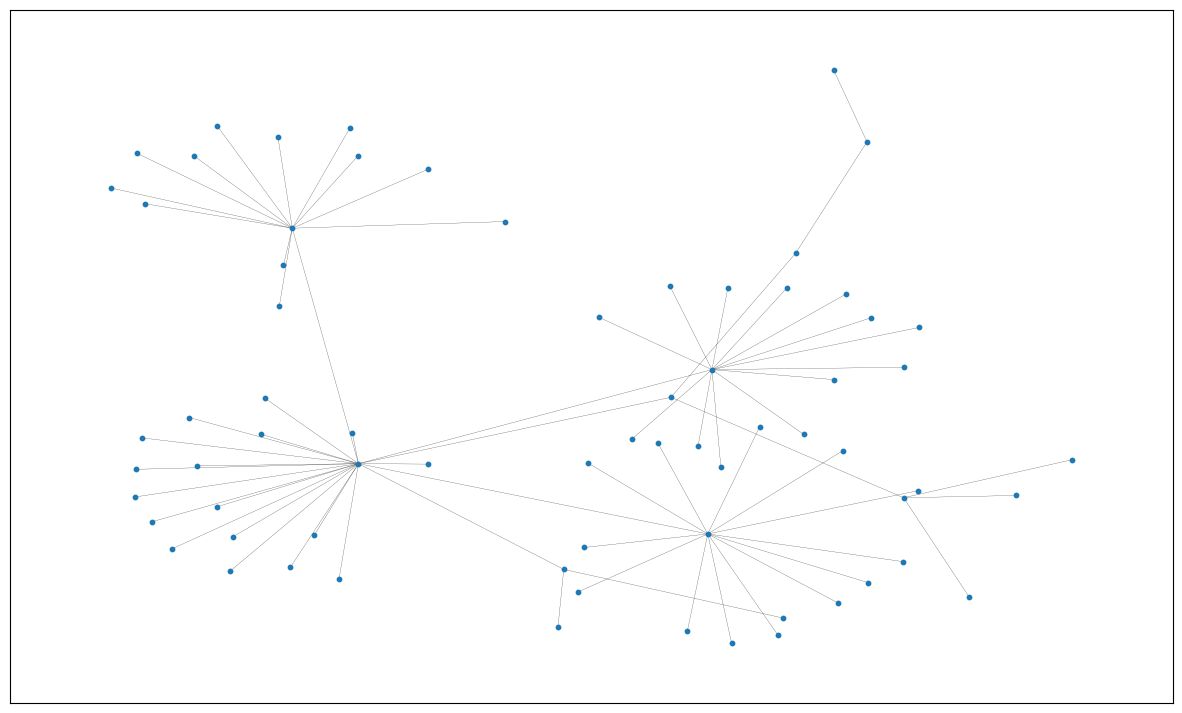

In [17]:
import matplotlib.pyplot as plt

print(graph)

plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
pos = nx.spring_layout(graph, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
nx.draw_networkx(graph, pos=pos, ax=ax, **plot_options)

In [75]:
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_community.graphs import ArangoGraph
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain
from langchain_core.tools import tool

In [9]:
import os
from dotenv import load_dotenv
load_dotenv()


os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

llm = ChatOpenAI(temperature=0, model_name="gpt-4o")

llm.invoke("hello!")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 9, 'total_tokens': 19, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'stop', 'logprobs': None}, id='run-4f9d09bc-1db1-4e82-861e-849e6025e17f-0', usage_metadata={'input_tokens': 9, 'output_tokens': 10, 'total_tokens': 19, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [10]:
G_adb = nxadb.Graph(
    name="ifc_graph",
    db=db,
    incoming_graph_data=graph,
    write_batch_size=5000,
    overwrite_graph=True
)

[21:16:59 +0300] [INFO]: Overwriting graph 'ifc_graph'
[21:17:00 +0300] [INFO]: Graph 'ifc_graph' exists.
[21:17:00 +0300] [INFO]: Default node type set to 'ifc_graph_node'
[2025/03/09 21:17:02 +0300] [15552] [INFO] - adbnx_adapter: Instantiated ADBNX_Adapter with database '_system'


Output()

Output()

[2025/03/09 21:17:04 +0300] [15552] [INFO] - adbnx_adapter: Created ArangoDB 'ifc_graph' Graph


In [77]:
arango_graph = ArangoGraph(db)

In [ ]:
import pandas as pd

main_result = {0:{}}

@tool
def text_to_aql_to_text(query: str):
    """This tool is available to invoke the
    ArangoGraphQAChain object, which enables you to
    translate a Natural Language Query into AQL, execute
    the query, and return the result back.
    """

    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")

    chain = ArangoGraphQAChain.from_llm(
    	llm=llm,
    	graph=arango_graph,
    	verbose=True,
        allow_dangerous_requests=True
    )
    chain.return_aql_result = True
    result = chain.invoke(query)
    main_result[0] = result['aql_result']

    return str(result["result"])

@tool
def object_finder_in_the_model(query: str):
    """This tool is available to invoke to
    find items, count items within the model when querried using natural language. enables to find items in the ifc
    database"""

    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")

    aql_query = llm.invoke(f"""
    I have a graph of the IFC model.
                    
    I want to find specific nodes in the model.
                    
    The graph nodes have attributes such as names, types and other IFC information that can be queried.

    An example query to find all the chairs looks like this: count nodes with type attribute that matches IfcFurniture and Name attribute that contains Chair and Dining and doesn't contain Table         

    add for similar word search not exact and look for IFC or Ifc prefix for attribute names and values
    
    give me a query to answer {query} from the model, be robust in trying to find all the items from the {query}, like excluding other items that are not realted to the item from the {query}. consider multiple case senstitvies, give the querry only.
    """)


    chain = ArangoGraphQAChain.from_llm(
    	llm=llm,
    	graph=arango_graph,
    	verbose=True,
        allow_dangerous_requests=True
    )

    result = chain.invoke({"messages": [{"role": "user", "content": aql_query}]})

    return str(result["result"])
    


In [ ]:
tools = [text_to_aql_to_text]

def query_graph(query):
    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")
    app = create_react_agent(llm, tools)    
    final_state = app.invoke({"messages": [{"role": "user", "content": query}]})
    return final_state["messages"][-1].content


In [ ]:
import gradio as gr

import pandas as pd
import numpy as np



def load_mesh():
    return "Ifc4_SampleHouse.glb"

def display_df_section():
    return pd.DataFrame(data=data)

def manage_response(message, history):
    global data
    answer = query_graph(message)
    data = main_result[0]
    return answer

data = main_result[0]

def export_node_attributes_dataframe(graph):
    """
    Exports the attributes of all nodes in a NetworkX graph as a pandas DataFrame.
    Args:
        graph (nx.Graph): The NetworkX graph.
    Returns:
        pandas.DataFrame: A DataFrame containing the node attributes.
    """
    node_data = []
    for node, attributes in graph.nodes(data=True):
        node_attributes = {"id": node}  
        node_attributes.update(attributes) 
        node_data.append(node_attributes)

    return pd.DataFrame(node_data)
df = export_node_attributes_dataframe(graph)

pds = pd.DataFrame({"": []})
frm = gr.DataFrame


with gr.Blocks() as demo:
    with gr.Tab("Home"):
        with gr.Row():
            with gr.Column(scale=1):
                gr.Model3D(value="Ifc4_SampleHouse.glb", clear_color=[0.0, 0.0, 0.0, 0.0],
                    label="3D Model", display_mode='solid',height=400)
            with gr.Column(scale=1):
                gr.ChatInterface(
                    fn=manage_response, 
                    type="messages"
                )
        with gr.Row():
            frm(display_df_section, every = 1)
        with gr.Sidebar():
            gr.Markdown(json_to_markdown_hierarchy(hierarchical_json))
    

demo.launch()

* Running on local URL:  http://127.0.0.1:7893

To create a public link, set `share=True` in `launch()`.


ping------------
content='```\ncount nodes with type attribute that matches (IfcDoor or IFCdoor or ifcdoor) and exclude nodes with type attribute that matches (IfcWindow or IFCwindow or ifcwindow or IfcFurniture or IFCfurniture or ifcfurniture) and exclude nodes with Name attribute that contains (Window or window or Furniture or furniture)\n```' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 70, 'prompt_tokens': 178, 'total_tokens': 248, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f9f4fb6dbf', 'finish_reason': 'stop', 'logprobs': None} id='run-624edbe6-a61d-405a-94a8-36992de120d2-0' usage_metadata={'input_tokens': 178, 'output_tokens': 70, 'total_tokens': 248, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_t